# Week VI - The Ising model and f2py (Part II)

In the last lecture, we have discussed a possible implementation of the **2D Ising model on a square lattice**. In particular, we have considered a system in equilibrium with a thermal bath, such that the temperature is constant. Temporal evolution is simulated through the **spin flip dynamics** in periodic boundary conditions (PBC).

We study the model by monitoring the following quantities:
* spin magnetisation 
    $$\frac{M}{N}  = \frac{1}{N}\sum_i s_i$$
* energy 
    $$\frac{E}{N} = \frac{1}{N}\sum_{NN(i,j)} s_i$$
* heat capacity
    $$c = \frac{<E^2>-<E>^2}{k_BT^2N}$$
* magnetic susceptibility
    $$\chi = \frac{<M^2>-<M>^2}{k_BTN}$$
    
> Today, we will see how to speed up the simulations by interfacing the Python and Fortran code.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Ising:
    '''
    This class implements 
    the 2D Ising model
    on a square lattice in PBCs
    '''
    
    def __init__(self,L,T,N_equi,N_mcs,sample_equi=False,data_filename='data.txt'):
        'Initialise the Ising model'
        self.L = L
        self.N = L**2
        self.T = T
        self.M = None
        self.M_N = None
        self.E = None
        self.E_N = None
        self.E_N_av = None
        self.M_N_av = None
        self.rng = np.random.default_rng(seed=42424)
        self.spin = np.zeros((L,L),dtype=np.int32)
        self.w_dict = {}
        self.acc = 0
        self.counter = 0
        self.N_equi = N_equi
        self.N_mcs = N_mcs
        self.data = []
        self.ar = None
        self.var = None
        self.sample_equi = sample_equi
        self.c_heat = None
        self.chi_mag = None
        self.autocorr = []
        self.n_autocorr = 10
        self.data_filename = data_filename 
    
    def make_pm(self,x):
        '''
        Convert random uniform array
        into array of -1 and +1
        '''
        def tmp(x):
            if x<0.5:
                return 1
            else:
                return -1
        f = np.frompyfunc(tmp, 1, 1)
        return f(x)
    
    def get_up_right(self,i,j):
        '''
        PBCs up/right
        '''
        if j==(self.L-1):
            up = 0
        else:
            up = j+1
        if i==(self.L-1):
            right = 0
        else:
            right = i+1
            
        return up,right
    
    def get_down_left(self,i,j):
        '''
        PBCs down/left
        '''
        if j==0:
            down = self.L-1
        else:
            down = j-1
        if i==0:
            left = self.L-1
        else:
            left = i-1
            
        return down,left
    
    def calc_energy(self):
        '''
        Calculates the total energy.
        NB: this is used only at initialization.
        '''
        E = 0
        for j in range(self.L):
            for i in range(self.L):
                up,right = self.get_up_right(i,j)
                E = E - self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])
        return E
                       
    def deltaE(self,i,j):
        '''
        Calculates change in energy for the spin flip
        '''
        up,right = self.get_up_right(i,j)
        down,left = self.get_down_left(i,j)
        res = 2.0*self.spin[i,j]*(self.spin[i,up]+self.spin[i,down]+self.spin[left,j]+self.spin[right,j])
        return (res,int(res))
    
    def initialize(self):
        '''
        Initialization of the system:
        -spins are randomly configured
        -energy is calculated from scratch
        -dictionary with Metropolis' probability
        coefficents is created
        '''
        r = self.rng.random((self.L,self.L))
        self.spin = self.make_pm(r)
        self.M = np.sum(self.spin)
        self.M_N = self.M/float(self.N)
        self.E = self.calc_energy()
        self.E_N = self.E/float(self.N)
        for dE in range(-8,8+1,4):
            self.w_dict[dE] = np.exp(-1.0*dE/self.T)
    
    def metro_step(self):
        'One step of Metropolis spin flip dynamics'
        for ispin in range(self.N):
            (ii,jj) = self.rng.integers(0,high=self.L,size=2)
            dE,dE_int = self.deltaE(ii,jj)
            rnd_w = self.rng.random()
            if (rnd_w<=self.w_dict[dE_int]):
                self.spin[ii,jj] = -1*self.spin[ii,jj]
                self.acc += 1
                self.M = self.M + 2* self.spin[ii,jj]
                self.M_N = self.M/float(self.N)
                self.E = self.E + dE
                self.E_N = self.E/float(self.N)
    

    def metro_driver(self,N_step,store=True):
        'Run N Metropolis steps of spin flip dynamics'
        for i in range(N_step):
            self.counter += self.N
            self.metro_step()
            if store:
                self.data.append((self.E,self.M))            
            
    def ising_driver(self):
        '''
        Main driver for the Monte Carlo
        '''
        self.initialize()
        self.metro_driver(self.N_equi,store=self.sample_equi)
        self.metro_driver(self.N_mcs)
        self.data = np.array(self.data)
        np.savetxt(self.data_filename,self.data)
    
    @staticmethod
    def plot_spin(spin):
        x,y = np.meshgrid(range(spin.shape[0]),range(spin.shape[1]))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.scatter(x,y,c=spin[x,y],label='spin')
        plt.title('spin configuration')
        plt.colorbar()
        plt.show()
    
    @staticmethod
    def calc_autocorr(a,N):
        'Autocorrelation function'
        res = np.ones(N)
        for k in range(1,N):
            c_k = np.average(a[:-k]*a[k:]) 
            x_r = np.average(a[:-k])
            x_r_2 = np.average(a[:-k]**2)
            res[k] = (c_k-x_r**2)/(x_r_2-x_r**2)
        return res
    
    def get_stats(self):
        '''
        Calculate, store and print 
        statistical quantities
        '''
        self.ar = self.acc*1.0/self.counter
        self.E_N_av =np.average(self.data[:,0])/self.N
        self.M_N_av = np.average(self.data[:,1])/self.N
        self.c_heat = (np.average(self.data[:,0]**2)- (self.E_N_av*self.N)**2)/(self.T**2*self.N)
        self.chi_mag = (np.average(self.data[:,1]**2)- (self.M_N_av*self.N)**2)/(self.T**2*self.N)
        print("Total number of steps run = {}".format(self.counter/self.N))
        print("Acceptance ratio = {}".format(self.ar))
        print("Temperature = {}".format(self.T))
        print("<E/N> = {}".format(self.E_N_av))
        print("<M/N> = {}".format(self.M_N_av))
        print("specific heat = {}".format(self.c_heat))
        print("magnetic susceptibility = {}".format(self.chi_mag))
        
    #def get_autocorr(self,n_autocorr=100):
    #    '''
    #    Wrapper for the autocorrelation
    #    function calculator
    #    '''
    #    a = np.array(self.data)
    #    self.autocorr = self.calc_autocorr(a,n_autocorr)

> Let's run the code!

In [2]:
# lateral size L (N=LxL), temperature T, nequil, nmcas
ising = Ising(30,2,1000,1000,sample_equi=True)
ising.initialize()

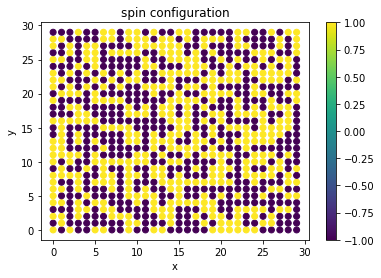

In [3]:
ising.plot_spin(ising.spin)

In [4]:
#Running Monte Carlo
ising.ising_driver()

In [5]:
#Extracting key quantities
ising.get_stats()

Total number of steps run = 2000.0
Acceptance ratio = 0.08374833333333333
Temperature = 2
<E/N> = -1.7314999999999998
<M/N> = 0.8793344444444444
specific heat = 1.5759748611111557
magnetic susceptibility = 4.240083110833334


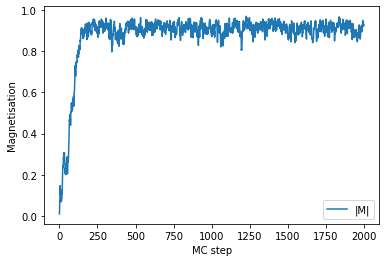

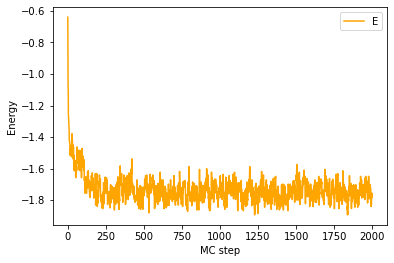

In [6]:
plt.ylabel('Magnetisation')
plt.xlabel('MC step')
plt.plot(np.abs(ising.data[:,1]/ising.N),'-',label='|M|')
plt.legend()
plt.show()
plt.close()
plt.ylabel('Energy')
plt.xlabel('MC step')
plt.plot(ising.data[:,0]/ising.N,'-',label='E',c='orange')
plt.legend()
plt.show()

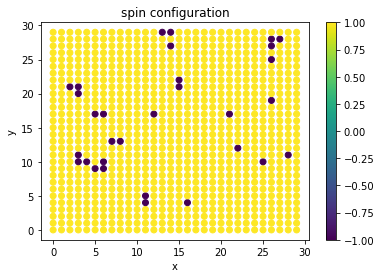

In [7]:
ising.plot_spin(ising.spin)

-----------------------------------

Now we increase the temperature to T=4.

Total number of steps run = 2000.0
Acceptance ratio = 0.6100044444444445
Temperature = 4
<E/N> = -0.5551266666666667
<M/N> = -0.0007644444444444443
specific heat = 0.17841576416666916
magnetic susceptibility = 0.25459546222222224


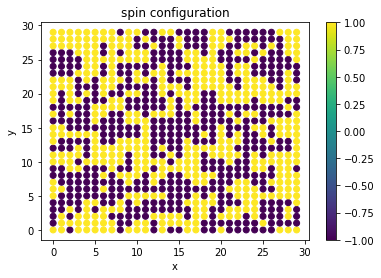

In [8]:
# lateral size L (N=LxL), temperature T, nequil, nmcas
ising = Ising(30,4,1000,1000,sample_equi=True)
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

-------------------------

>There seems to be a phase transition between T=2 and T=4, let's investigate what happens as a function of temperature.

In [9]:
res=[]
T_list = np.linspace(1.5,4,10)
for T in T_list:
    ising = Ising(30,T,1000,1000,sample_equi=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)


Total number of steps run = 2000.0
Acceptance ratio = 0.018533888888888888
Temperature = 1.5
<E/N> = -1.9506888888888887
<M/N> = 0.986331111111111
specific heat = 0.1757706666668808
magnetic susceptibility = 0.01645866469135163
Total number of steps run = 2000.0
Acceptance ratio = 0.04475222222222222
Temperature = 1.7777777777777777
<E/N> = -1.8705511111111113
<M/N> = 0.9606044444444444
specific heat = 0.37400694749985636
magnetic susceptibility = 0.053845335000019076
Total number of steps run = 2000.0
Acceptance ratio = 0.09907944444444444
Temperature = 2.0555555555555554
<E/N> = -1.705008888888889
<M/N> = 0.89312
specific heat = 0.6883804652738945
magnetic susceptibility = 0.19872923956172023
Total number of steps run = 2000.0
Acceptance ratio = 0.23376388888888888
Temperature = 2.3333333333333335
<E/N> = -1.3193422222222222
<M/N> = 0.5446533333333333
specific heat = 1.671281946122513
magnetic susceptibility = 4.12450217469388
Total number of steps run = 2000.0
Acceptance ratio = 0.3

In [12]:
#plotting as a function of temperature
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2)
    axs[0,0].plot(T_list,res[:,0],'o-',c='orange',label='energy')
    axs[0,1].plot(T_list,np.abs(res[:,1]),'o-',label='magnetisation')
    axs[1,0].plot(T_list,res[:,2],'o-',c='red',label='specific heat')
    axs[1,1].plot(T_list,res[:,3],'o-',c='k',label='magnetic susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.set_xlim([1.5,4])
            ax.axvline(x=2.26,c='grey')


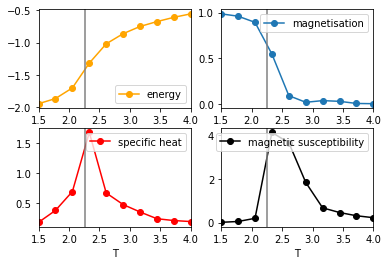

In [13]:
plot_res(T_list,res)

>A proper sampling requires more computational time, let's load some results computed with this code for longer runs (10000 steps) and with a more dense sampling of temperatures.

In [14]:
res = np.loadtxt('./res_acc.txt')
T_list = np.loadtxt('./T_acc.txt')
plot_res(T_list,res)

OSError: ./res_acc.txt not found.

### Profiling
In the next lecture we will see how to make the code faster by integrating Fortran subroutines into Python code with *f2py*.\
For the moment, we will just investigate where the code spends most of the run time.

In [15]:
%load_ext line_profiler

In [16]:
ising = Ising(10,1,100,1000,sample_equi=False)
ising.initialize()
%lprun -f ising.ising_driver ising.ising_driver()

In [17]:
ising = Ising(10,1,100,1000,sample_equi=False)
ising.initialize()
%lprun -f ising.metro_step ising.ising_driver()

-------------------------

# f2py - interfacing Fortran code to Python

From https://numpy.org/doc/stable/f2py/ :

"The purpose of the F2PY –Fortran to Python interface generator– utility is to provide a connection between Python and Fortran. F2PY is a part of NumPy (numpy.f2py) and also available as a standalone command line tool.

F2PY facilitates creating/building Python C/API extension modules that make it possible

* to call Fortran 77/90/95 external subroutines and Fortran 90/95 module subroutines as well as C functions;
* to access Fortran 77 COMMON blocks and Fortran 90/95 module data, including allocatable arrays

from Python".


There are different ways to use f2py, today we will first create an interface and then compile the Fortran code as a Python module:


* python3 -m numpy.f2py isingmetro.f90 -m isingf -h ising.pyf
* python3 -m numpy.f2py -c ising.pyf isingmetro.f90

In [18]:
!rm ising.pyf
!python3 -m numpy.f2py isingmetro.f90 -m isingf -h ising.pyf

rm: cannot remove 'ising.pyf': No such file or directory


Reading fortran codes...
	Reading file 'isingmetro.f90' (format:free)
Post-processing...
	Block: isingf
			Block: isingf
				Block: init
				Block: alloc
				Block: metropolis
				Block: deltae
Post-processing (stage 2)...
	Block: isingf
		Block: unknown_interface
			Block: isingf
				Block: init
				Block: alloc
				Block: metropolis
				Block: deltae
Saving signatures to file ".\ising.pyf"
{'attrspec': ['public']}
In: :isingf:isingmetro.f90:isingf
vars2fortran: No typespec for argument "init".
{'attrspec': ['public']}
In: :isingf:isingmetro.f90:isingf
vars2fortran: No typespec for argument "metropolis".
{'attrspec': ['public']}
In: :isingf:isingmetro.f90:isingf
vars2fortran: No typespec for argument "deltae".


In [20]:
!python3 -m numpy.f2py -c ising.pyf isingmetro.f90

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "isingf" sources
creating C:\Users\Utente\AppData\Local\Temp\tmp94_4o11g\src.win-amd64-3.9
f2py options: []
f2py: ising.pyf
Reading fortran codes...
	Reading file 'ising.pyf' (format:free)
Post-processing...
	Block: isingf
			Block: isingf
				Block: init
				Block: alloc
				Block: metropolis
				Block: deltae
Post-processing (stage 2)...
	Block: isingf
		Block: unknown_interface
			Block: isingf
				Block: init
				Block: alloc
				Block: metropolis
				Block: deltae
Building modules...
	Building module "isingf"...
		Constructing F90 module support for "isingf"...
		  Variables: seed l n nmcs nequil w spin t e m accept
getarrdims:warning: assumed shape array, using 0 instead of ':'
getarrdims:warning: assumed shape array, 

error: extension 'isingf' has Fortran sources but no Fortran compiler found



Could not locate executable f90
customize CompaqVisualFCompiler
Found executable C:\Users\Utente\miniconda3\Library\usr\bin\DF.exe
customize IntelItaniumVisualFCompiler
Could not locate executable efl
customize Gnu95FCompiler
Could not locate executable gfortran
Could not locate executable f95
customize G95FCompiler
Could not locate executable g95
customize IntelEM64VisualFCompiler
customize IntelEM64TFCompiler
Could not locate executable efort
Could not locate executable efc
customize PGroupFlangCompiler
Could not locate executable flang
don't know how to compile Fortran code on platform 'nt'

building 'isingf' extension


In [21]:
# useful function recycled from the Python class for the Ising model
import numpy as np
import matplotlib.pyplot as plt
def get_up_right(L,i,j):
        '''
        PBCs up/right
        '''
        if j==(L-1):
            up = 0
        else:
            up = j+1
        if i==(L-1):
            right = 0
        else:
            right = i+1
            
        return up,right
def get_down_left(L,i,j):
        '''
        PBCs down/left
        '''
        if j==0:
            down = L-1
        else:
            down = j-1
        if i==0:
            left = L-1
        else:
            left = i-1
            
        return down,left
def calc_energy(L,spin):
        '''
        Calculates the total energy.
        NB: this is used only at initialization.
        '''
        E = 0
        for j in range(L):
            for i in range(L):
                up,right = get_up_right(L,i,j)
                E = E - spin[i,j]*(spin[i,up]+spin[right,j])
        return E
def get_stats(data,N,T):
        '''
        Calculate, store and print 
        statistical quantities
        '''
        E_N_av =np.average(data[:,0])/N
        M_N_av = np.average(data[:,1])/N
        c_heat = (np.average(data[:,0]**2)- (E_N_av*N)**2)/(T**2*N)
        chi_mag = (np.average(data[:,1]**2)- (M_N_av*N)**2)/(T**2*N)
        #print("Total number of steps run = {}".format(counter/N))
        #print("Acceptance ratio = {}".format(ar))
        #print("Temperature = {}".format(self.T))
        print("<E/N> = {}".format(E_N_av))
        print("<M/N> = {}".format(M_N_av))
        print("specific heat = {}".format(c_heat))
        print("magnetic susceptibility = {}".format(chi_mag))     
        return E_N_av,M_N_av,c_heat,chi_mag

In [ ]:
from isingf import isingf

In [ ]:
isingf.t  = 1
isingf.l = 30
isingf.n = 30*30

In [ ]:
isingf.alloc()
isingf.init()
isingf.w

In [ ]:
isingf.spin = np.ones((30,30),dtype=np.int32,order='F')

In [ ]:
isingf.e = calc_energy(isingf.l,isingf.spin)
isingf.m = np.sum(isingf.spin)

In [ ]:
isingf.e,isingf.m

In [ ]:
isingf.metropolis()
isingf.spin

In [ ]:
isingf.e

In [ ]:
N_eq = 10000
data=np.zeros((N_eq,2))
for i in range(N_eq):
    isingf.metropolis()
    data[i,:] = (isingf.e,isingf.m)

In [ ]:
plt.plot(np.abs(data[:,1])/isingf.n,'o-')

In [ ]:
get_stats(data,isingf.n,isingf.t)

In [ ]:
from isingf import isingf
N_eq = 1000
N_mc = 100000
T_list = np.linspace(1.5,4,30)
res_f = []
for T in T_list:
    isingf.t  = T
    isingf.l = 30
    isingf.n = 30*30
    #isingf.alloc()
    isingf.init()
    isingf.spin = np.ones((30,30),dtype=np.int32,order='F')
    isingf.e = calc_energy(isingf.l,isingf.spin)
    isingf.m = np.sum(isingf.spin)
    data=np.zeros((N_mc,2))
    for i in range(N_eq):
        isingf.metropolis()
    for i in range(N_mc):
        isingf.metropolis()
        data[i,:] = (isingf.e,isingf.m)
    e,m,heat,chi = get_stats(data,isingf.n,isingf.t)
    res_f.append([e,m,heat,chi])
#    del isingf
res_f = np.array(res_f)



In [ ]:
plot_res(T_list,res_f)

> Notice how much faster this code is with respect to the pure Python code!

## Profiling - revisited

In [ ]:
from isingf import isingf
def run_isingf(T,N_eq,N_mc):
    isingf.t  = T
    isingf.l = 30
    isingf.n = 30*30
    #isingf.alloc()
    isingf.init()
    isingf.spin = np.ones((30,30),dtype=np.int32,order='F')
    isingf.e = calc_energy(isingf.l,isingf.spin)
    isingf.m = np.sum(isingf.spin)
    data=np.zeros((N_mc,2))
    for i in range(N_eq):
        isingf.metropolis()
    for i in range(N_mc):
        isingf.metropolis()
        data[i,:] = (isingf.e,isingf.m)
    return get_stats(data,isingf.n,isingf.t)


In [ ]:
ising = Ising(30,2,1000,2000,sample_equi=False)
ising.initialize()
%time ising.ising_driver() 
%time run_isingf(2,1000,2000) 

In [ ]:
%load_ext line_profiler
%lprun -f run_isingf run_isingf(2,1000,2000) 